### Use LPE to overfit over reference image (based on Local Positional Encoding for Multi-Layer Perceptrons)

In [1]:
import torch
import torchvision

# load reference image
ref_img = torchvision.io.read_image(r".\reference.png", mode=torchvision.io.ImageReadMode.RGB)
ref_img = ref_img.float() / 255.0 # convert to [0;1]

# hyperparameters
epochs = 1000
samples_per_epoch = 60000
grid_size = 64
frequencies = 4
latent_coefficients_num = frequencies * 2 * 2 # first 2 - uv, second 2 - sin/cos encoding

grid = (torch.rand( (grid_size, grid_size, latent_coefficients_num) ) - 1) * 10e-5 # [-10e-5;10e-5]
grid.requires_grad_()

mlp = torch.nn.Sequential( 
    torch.nn.Linear( latent_coefficients_num, 64 ),
    torch.nn.LeakyReLU(negative_slope=0.1),
    torch.nn.Linear( 64, 64 ),
    torch.nn.LeakyReLU(negative_slope=0.1),
    torch.nn.Linear( 64, 64 ),
    torch.nn.LeakyReLU(negative_slope=0.1),
    torch.nn.Linear( 64, 3 ),
    torch.nn.Sigmoid()
)
optimizer_grid = torch.optim.Adam( [grid], lr=0.02 )
optimizer_mlp = torch.optim.Adam( mlp.parameters(), lr=0.02 )
loss = torch.nn.MSELoss()

def get_local_position(uv : torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    x_g = uv * (grid_size - 1)
    z = torch.floor(x_g)
    x_l = x_g - z
    z = z.to(torch.int32)
    return z, x_l

def local_positional_encoding(uv : torch.Tensor, grid : torch.Tensor, frequencies : int) -> torch.Tensor:
    z, x_l = get_local_position(uv)

    z_x = z[:,0]
    z_y = z[:,1]
    a_0 = grid[z_x  , z_y  ]
    a_1 = grid[z_x+1, z_y  ]
    a_2 = grid[z_x  , z_y+1]
    a_3 = grid[z_x+1, z_y+1]

    # bilinear interpolation
    tx = x_l[:, 0:1]
    ty = x_l[:, 1:2]
    w00 = (1 - tx) * (1 - ty)
    w10 = tx * (1 - ty)
    w01 = (1 - tx) * ty
    w11 = tx * ty
    a = a_0 * w00 + a_1 * w10 + a_2 * w01 + a_3 * w11

    powers = 2 ** torch.arange(0, frequencies) * torch.pi
    powers_x = torch.outer(x_l[:,0], powers)
    powers_y = torch.outer(x_l[:,1], powers)

    cossin_x = torch.cos(powers_x), torch.sin(powers_x)
    cossin_y = torch.cos(powers_y), torch.sin(powers_y)

    # reduce discontinuities at the edges of the grid cells
    cossin_x[0][:, 0] = 1
    cossin_x[1][:, 0] = 1
    cossin_y[0][:, 0] = 1
    cossin_y[1][:, 0] = 1

    lpe = a * torch.cat( [cossin_x[0], cossin_x[1], cossin_y[0], cossin_y[1]], dim=1 )
    return lpe

for epoch in range(epochs):
    uv = torch.rand((samples_per_epoch, 2))

    lpe = local_positional_encoding(uv, grid, frequencies)

    predicted_rgb = mlp(lpe)

    # gather ground through samples from ref_img
    sample_grid = uv * 2 - 1
    sample_grid = sample_grid.unsqueeze(0).unsqueeze(2)
    ref_samples = torch.nn.functional.grid_sample(ref_img.unsqueeze(0), sample_grid, mode="bilinear", align_corners=False)
    ref_samples = ref_samples.reshape(3,-1).permute(1,0)

    # loss computation and backpropagation
    loss_value = loss(predicted_rgb, ref_samples)

    optimizer_mlp.zero_grad()
    optimizer_grid.zero_grad()

    loss_value.backward()

    optimizer_mlp.step()
    optimizer_grid.step()


### Use learned parameters to compare with reference image

PSNR: 18.557579040527344


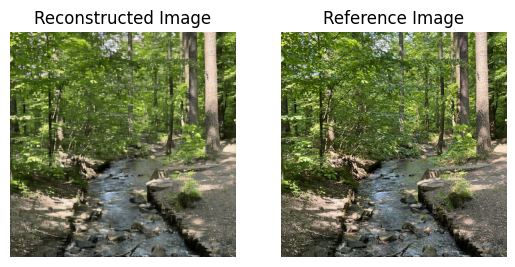

In [2]:
import matplotlib.pyplot as plt

with torch.no_grad():
    
    c, h, w = ref_img.shape
    y = (torch.arange(0, h, dtype=torch.float32) + 0.5) / h
    x = (torch.arange(0, w, dtype=torch.float32) + 0.5) / w

    grid_uv = torch.stack( torch.meshgrid(x, y, indexing='xy'), dim=-1 ).reshape(-1,2)

    lpe = local_positional_encoding(grid_uv, grid, frequencies)

    predicted_rgb = mlp(lpe)

    predicted_rgb = predicted_rgb.reshape(h, w, 3)

    rgb = torch.zeros(predicted_rgb.shape[0], predicted_rgb.shape[1], 3)
    rgb[..., 0] = predicted_rgb[..., 0]
    rgb[..., 1] = predicted_rgb[..., 1]
    rgb[..., 2] = predicted_rgb[..., 2]

    # PSNR
    mse = torch.mean((rgb.to(torch.float32) - ref_img.permute(1,2,0).to(torch.float32)) ** 2)
    mse = torch.inf if mse == 0 else mse
    psnr = 10 * torch.log10(1.0 / (mse + 1e-20))
    print("PSNR:", psnr.item())

    fig, axs = plt.subplots(1, 2)
    img = rgb.clamp(0.0, 1.0).cpu().numpy()
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title('Reconstructed Image')

    img = ref_img.permute(1, 2, 0).cpu().numpy()
    axs[1].imshow(img)
    axs[1].axis('off')
    axs[1].set_title('Reference Image')
    plt.show()
